In [26]:
from scipy.io import loadmat
from scipy.stats import circmean, circstd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

from utils import validate_data

## Loading all the data

In [27]:
# Set in stone
data_path = '../axej/'
n_subjects = 13
n_sessions = 4
n_runs = 6
n_trials = 120
n_ts = 500

exp_ts = 1000

# noise frames = 0 to 220 (250 - 30)
noise_thresh = 0.5
noise_gap = 30


experiment_orientations = [159, 123, 87, 51, 15]
subjects = ["01", "02", "03", "04", "05", "06", "07", "08" ,"09", "10", "11", "12", "14"]

def get_calib(subj, sess):
    mat_contents = loadmat(data_path + f'AxeJEEG_Subj{subjects[subj]}_S{sess+1}_Cali1.mat.mat', struct_as_record=False, squeeze_me=True)
    return mat_contents["p"].__dict__

def get_run(subj, sess, run):
    mat_contents = loadmat(data_path + f'AxeJEEG_Subj{subjects[subj]}_S{sess+1}_Run{run+1}.mat.mat', struct_as_record=False, squeeze_me=True)
    return mat_contents["p"].__dict__

In [28]:
# Get all run data
# subjexts x sessions x runs
jx = []
jy = []
stimdir = []
tgonset = []

# Attention (attCue): tr_foc = 1, tr_div = 2
# Coherence (tgCoh): tr_lo = 1, tr_hi = 2
att = []
coh = []

for subj in tqdm(range(n_subjects)):
    for sess in range(n_sessions):
        for run in range(n_runs):

            data = get_run(subj, sess, run)
            jx.append(data["joyx"])
            jy.append(data["joyy"])
            stimdir.append(data["stimDirREAL"])

            f_tgonset = data["f_precuedur"] + data["f_cuedur"]
            tgonset.append(f_tgonset)

            att.append(data["attCue"])
            coh.append(data["tgCoh"])

# Shape the run data
jx = np.array(jx, dtype=np.float64).reshape(n_subjects, n_sessions, n_runs, n_trials, n_ts)
jy = np.array(jy, dtype=np.float64).reshape(n_subjects, n_sessions, n_runs, n_trials, n_ts)
stimdir = np.array(stimdir).reshape(n_subjects, n_sessions, n_runs, n_trials)
tgonset = np.array(tgonset).reshape(n_subjects, n_sessions, n_runs, n_trials)
att = np.array(att).reshape(n_subjects, n_sessions, n_runs, n_trials)
coh = np.array(coh).reshape(n_subjects, n_sessions, n_runs, n_trials)

jx.shape, jy.shape, stimdir.shape, tgonset.shape

100%|██████████| 13/13 [00:01<00:00,  9.70it/s]


((13, 4, 6, 120, 500), (13, 4, 6, 120, 500), (13, 4, 6, 120), (13, 4, 6, 120))

## Logic for Getting Valid Trials:

1. Get all the trials
2. Align all target onset at 250 ts
3. Get distance from center and angle from center
4. If the distance moves <0.4 au n frames before target onset. Then that trial is "too early" and all response set nan.
5. If ts has distance > 1 au then set its response angle to the last valid angle (if first, the nan) and set that distance to 1.
6. get angle first distance = 1 a.u. instance after target onset. or if it never reaches 1, then angle at max distance after target onset. as the response angle.

In [29]:
shifted_jx, shifted_jy, dist_from_cent, resp_angle, final_resp_angles = validate_data(n_subjects, n_sessions, n_runs, n_trials, n_ts, exp_ts, jx, jy, tgonset, noise_thresh, noise_gap)

In [30]:
# Get all trials where angles are only nan
nan_trials = np.where(np.isnan(resp_angle).all(axis=-1))
print(nan_trials[0].shape[0], "removed trials")
print(nan_trials[0].shape[0] / (n_subjects * n_sessions * n_runs * n_trials) * 100, "% removed trials")

2919 removed trials
7.7964743589743595 % removed trials


## Circular stat defs

In [31]:
def circdist(a, b):
    return min(abs(a-b), 360-abs(a-b))

def circmedian(angs):
    angs = np.array(angs)
    angs = angs[~np.isnan(angs)]
    pdists = angs[np.newaxis, :] - angs[:, np.newaxis]
    pdists = (pdists + 180) % (2 * 180) - 180
    pdists = np.abs(pdists).sum(1)
    return angs[np.argmin(pdists)]

In [32]:
calib_median = np.load("../cache/calib_results/circ_median.npy")
median_key = {15:0, 51:1, 87:2, 123:3, 159:4}

In [33]:
calib_std = np.load("../cache/calib_results/circ_std.npy")
std_key = {15:0, 51:1, 87:2, 123:3, 159:4}

## Figure recreations

In [34]:
# get error angle over time

calib_error_angle = np.zeros_like(resp_angle)
calib_error_angle[:] = np.nan

for sub in range(n_subjects):
    for sess in range(n_sessions):
        for run in range(n_runs):
            for trial in range(n_trials):
                t = stimdir[sub,sess,run,trial]
                a = calib_median[sub,median_key[t]]
                for ts in range(n_ts):
                    if np.isnan(resp_angle[sub,sess,run,trial,ts]):continue
                    b = resp_angle[sub,sess,run,trial,ts]
                    calib_error_angle[sub,sess,run,trial,ts] = circdist(a,b)

### Attention and coherence

In [35]:
att.shape, coh.shape

((13, 4, 6, 120), (13, 4, 6, 120))

In [36]:
foc_err = calib_error_angle[np.where(att == 1)]
div_err = calib_error_angle[np.where(att == 2)]

lo_err = calib_error_angle[np.where(coh == 1)]
hi_err = calib_error_angle[np.where(coh == 2)]

/tmp/ipykernel_53922/732924122.py:8: RuntimeWarning: Mean of empty slice
  plt.plot((np.array(range(-250, 750, 1))*fr)[:], np.nanmean(foc_err, axis=(0))[:], 'c-')
/tmp/ipykernel_53922/732924122.py:9: RuntimeWarning: Mean of empty slice
  plt.plot((np.array(range(-250, 750, 1))*fr)[:], np.nanmean(div_err, axis=(0))[:], 'c--')


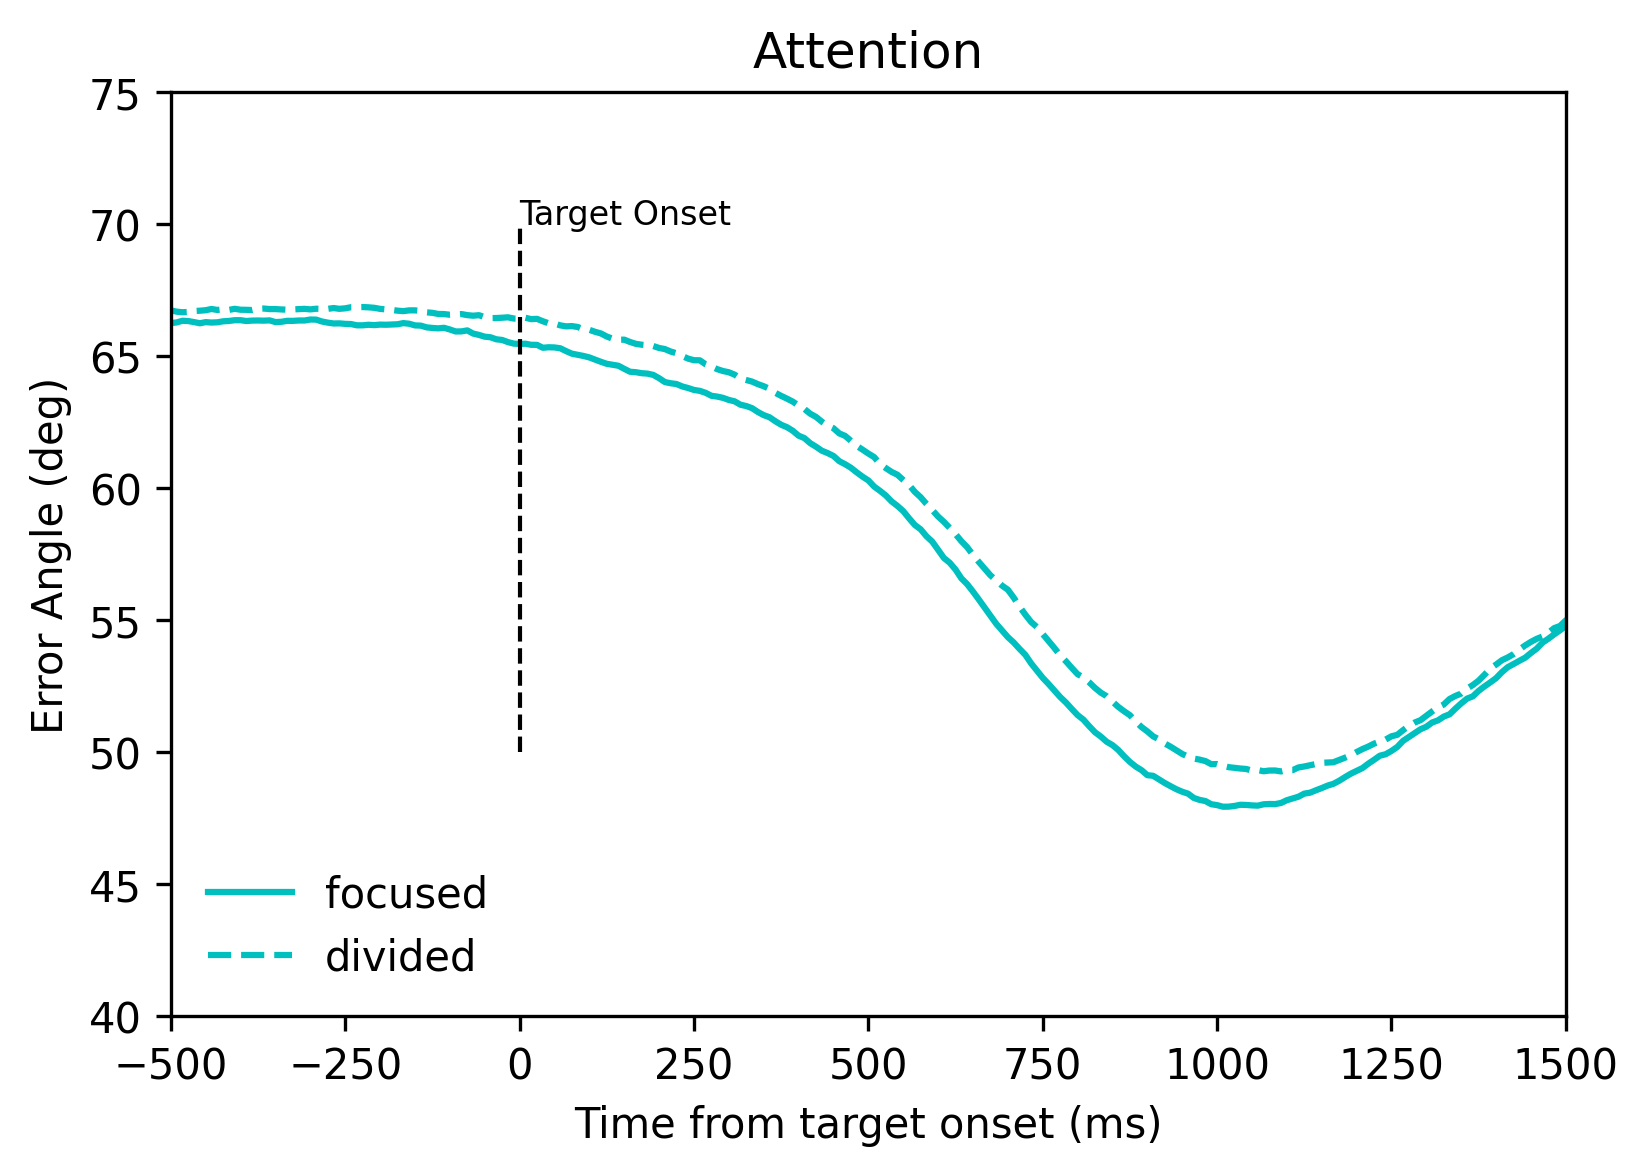

In [37]:
# Take the erros and mean across trials

x_crop = 150

fr = 1000/120

plt.figure(figsize=(6, 4), dpi=300)
plt.plot((np.array(range(-250, 750, 1))*fr)[:], np.nanmean(foc_err, axis=(0))[:], 'c-')
plt.plot((np.array(range(-250, 750, 1))*fr)[:], np.nanmean(div_err, axis=(0))[:], 'c--')
plt.xlabel('Time from target onset (ms)')
plt.ylabel('Error Angle (deg)')
plt.title('Attention')

plt.legend(['focused', 'divided'], loc='lower left', frameon=False)

plt.ylim(40, 75)
plt.xlim(-500, 1500)

# Add note that 0 is the point of target onset
plt.plot([0, 0], [50, 70], 'k--', lw=1)
plt.text(0, 70, 'Target Onset', fontsize=8)

plt.show()

/tmp/ipykernel_53922/3026930331.py:8: RuntimeWarning: Mean of empty slice
  plt.plot((np.array(range(-250, 750, 1))*fr)[:], np.nanmean(hi_err, axis=(0))[:], 'k-')
/tmp/ipykernel_53922/3026930331.py:9: RuntimeWarning: Mean of empty slice
  plt.plot((np.array(range(-250, 750, 1))*fr)[:], np.nanmean(lo_err, axis=(0))[:], 'k--')


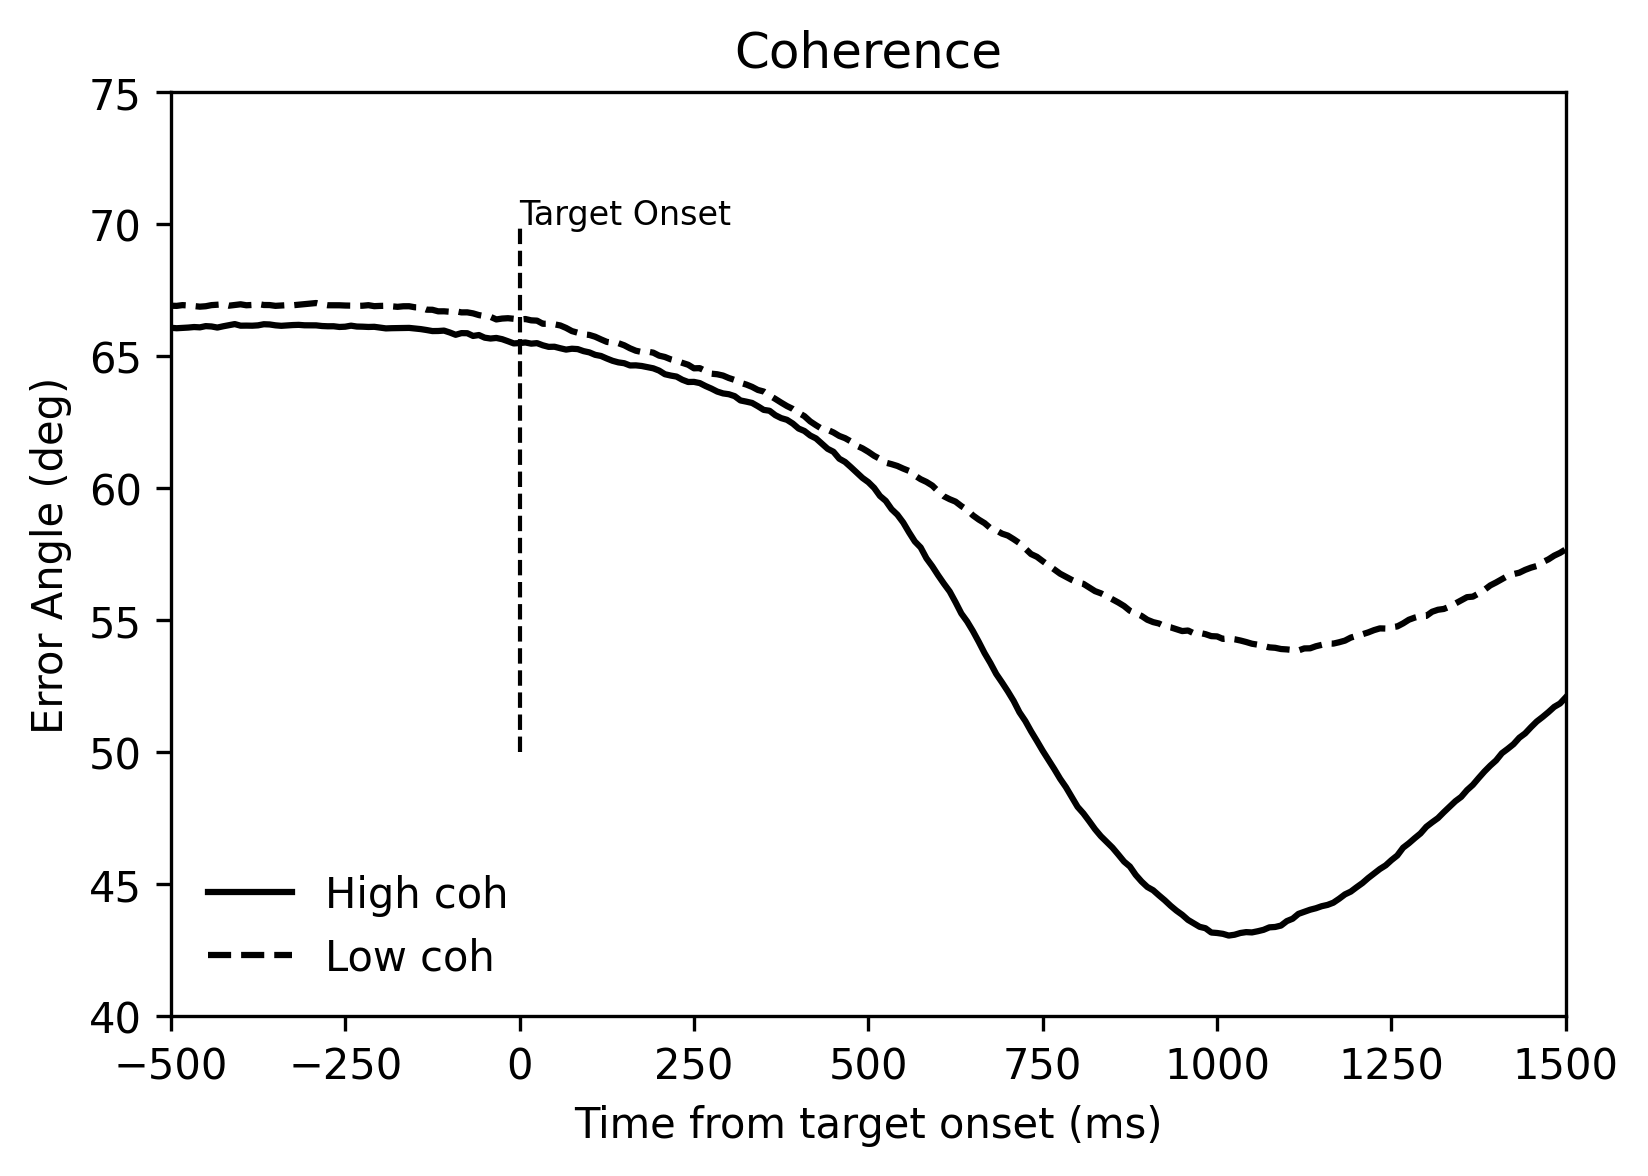

In [38]:
# Take the erros and mean across trials

x_crop = 150

fr = 1000/120

plt.figure(figsize=(6, 4), dpi=300)
plt.plot((np.array(range(-250, 750, 1))*fr)[:], np.nanmean(hi_err, axis=(0))[:], 'k-')
plt.plot((np.array(range(-250, 750, 1))*fr)[:], np.nanmean(lo_err, axis=(0))[:], 'k--')
plt.xlabel('Time from target onset (ms)')
plt.ylabel('Error Angle (deg)')
plt.title('Coherence')

plt.legend(['High coh', 'Low coh'], loc='lower left', frameon=False)

plt.ylim(40, 75)
plt.xlim(-500, 1500)

# Add note that 0 is the point of target onset
plt.plot([0, 0], [50, 70], 'k--', lw=1)
plt.text(0, 70, 'Target Onset', fontsize=8)

plt.show()

## Accuracy and performance

In [39]:
final_resp_angles.shape, stimdir.shape

((13, 4, 6, 120), (13, 4, 6, 120))

In [40]:
# One and two sigma distance from the calibration median

resp_correct_sigma = np.zeros_like(final_resp_angles)
resp_correct_sigma[:] = np.nan

resp_correct_two_sigma = np.zeros_like(final_resp_angles)
resp_correct_two_sigma[:] = np.nan

for subj in range(n_subjects):
    for sess in range(n_sessions):
        for run in range(n_runs):
            for trial in range(n_trials):
                actual_stimdir = stimdir[subj,sess,run,trial]

                # Get the median and std for the actual stimdir
                calib_resp_median = calib_median[subj,median_key[actual_stimdir]]
                calib_resp_sigma = calib_std[subj,std_key[actual_stimdir]]

                # Get the response angle
                trial_response = final_resp_angles[subj,sess,run,trial]

                # Skip if the trial is 'too early'
                if np.isnan(trial_response): continue

                # Check if the response is within 1 sigma or 2 sigma
                resp_correct_sigma[subj,sess,run,trial] = circdist(calib_resp_median, trial_response) <= calib_resp_sigma
                resp_correct_two_sigma[subj,sess,run,trial] = circdist(calib_resp_median, trial_response) <= calib_resp_sigma*2


In [41]:
# count nans
print(np.isnan(final_resp_angles).sum())

2919


In [42]:
acc_result = np.zeros((n_subjects, 3))

for subj in range(n_subjects):
    acc_result[subj, 0] = np.nanmean(resp_correct_sigma[subj]) * 100
    acc_result[subj, 1] = np.nanmean(resp_correct_two_sigma[subj]) * 100
    acc_result[subj, 2] = np.unique(resp_correct_sigma[subj], return_counts=True)[1][-1]

In [43]:
acc_df = pd.DataFrame(acc_result, columns=['1 sigma', '2 sigma', 'too early'])
acc_df.index = subjects
acc_df

,1 sigma,2 sigma,too early
01,21.701323,33.270321,235.0
02,44.285215,64.522894,19.0
03,26.065999,41.490545,183.0
04,20.400985,33.204362,37.0
05,35.844642,49.929808,743.0
06,32.962448,55.354659,4.0
07,24.904348,37.217391,5.0
08,15.445026,26.308901,1352.0
09,27.671134,38.500543,119.0
10,43.926908,68.004300,89.0


Text(0, 0.5, 'Accuracy (%)')

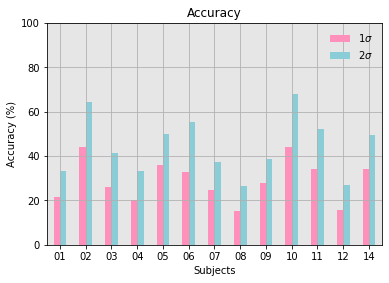

In [44]:
# barplot only columns 1 sigma and 2 sigma
# #FF90BC, #FFC0D9, #F9F9E0, #8ACDD7

fig = plt.figure(figsize=(6, 4), dpi=72)

ax = acc_df.iloc[:, :2].plot.bar(rot= 0,legend=True, title='Accuracy', ylim=(0, 100), color=['#FF90BC', '#8ACDD7'], grid=True, ax = plt.gca())

ax.set_facecolor('0.90')
ax.legend([r"1$\sigma$", r"2$\sigma$"],loc='upper right', frameon=False)
ax.set_xlabel("Subjects")
ax.set_ylabel("Accuracy (%)")


In [45]:
acc_df.round(2)

,1 sigma,2 sigma,too early
01,21.70,33.27,235.0
02,44.29,64.52,19.0
03,26.07,41.49,183.0
04,20.40,33.20,37.0
05,35.84,49.93,743.0
06,32.96,55.35,4.0
07,24.90,37.22,5.0
08,15.45,26.31,1352.0
09,27.67,38.50,119.0
10,43.93,68.00,89.0
